# Template for analyzing the CLM5-PPE
- Updated August 3, 2021
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

## spin up some extra cores on CASPER

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
#only run once
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/work/dlawren/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45128 instead
  expected, actual


In [4]:
#note that you should eventually see your workers in the output here
# you can rerun this cell, to check that the job made it through the queue
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:44887,Workers: 0
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,Total threads: 0
Started: Just now,Total memory: 0 B


## A few useful functions

In [5]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [6]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [7]:
def param_effect(da,p,uniques,cf,vartype):
    nyrs=10

    x0      = (cf*month_wts(nyrs)*lareg*da).compute()
    x1      = 1/nyrs*x0.sum(dim='time').compute()
    
    mean    = x1.sum(dim='gridcell').compute()
    iav     = x0.sum(dim='gridcell').groupby('time.year').sum().std(dim='year').compute()
    xdefs   = np.array([mean.sel(ens=0).values,iav.sel(ens=0).values])

#    if vartype == "MAX":
#        var_domainavg     = (ds[var]).mean(dim='gridcell')
#        var_domainavg_ann = cf/(month_wts(10).mean())*(month_wts(10)*var_domainavg).groupby('time.month').mean()
#        mean = var_domainavg_ann.max(dim='month').compute()
#        iav       = var_domainavg_ann.std(dim='year').compute()

#    if vartype == "MEAN":
#        var_domainavg     = (ds[var]).mean(dim='gridcell')
#        var_domainavg_ann = cf/(month_wts(10).mean())*(month_wts(10)*var_domainavg).groupby('time.year').mean()
#        mean      = var_domainavg_ann.mean(dim='year').compute()
#        iav       = var_domainavg_ann.std(dim='year').compute()
    
#    if vartype == "SUM":
#        var_domainavg     = (la*ds[var]).sum(dim='gridcell')
#        var_domainavg_ann = cf*(month_wts(10)*var_domainavg).groupby('time.year').sum()
#        mean      = var_domainavg_ann.mean(dim='year').compute()
#        iav       = var_domainavg_ann.std(dim='year').compute()

    
    effect_on_mean =[]
    effect_on_iav  =[]
    dxs            =[]
    for param in uniques:
        print(param)
        ix    = p==param
        xvals = x1.isel(ens=ix)
        mean2 = mean.isel(ens=ix)
        iav2  = iav.isel(ens=ix)
        
        if len(mean2)==2:
            #has min and max
            effect_on_mean.append(abs(mean2[0]-mean2[1]).values)
            effect_on_iav.append(abs(iav2[0]-iav2[1]).values)
            dxs.append(xvals[:,0]-xvals[:,1])
        else:
            #only has one or the other, sub in default x[0]
            effect_on_mean.append(abs(mean[0]-mean2[0]).values)
            effect_on_iav.append(abs(iav[0]-iav2[0]).values)
            dxs.append(x1.sel(ens=0)-xvals[:,0])

    dx      = xr.concat(dxs,dim='ens')
    r2      = np.corrcoef(dx)**2
    r2[np.isnan(r2)]=1   #this is to correct for BFBs
    spatial = r2.sum(axis=0)
            
    effect_on_mean = np.array(effect_on_mean)
    effect_on_iav  = np.array(effect_on_iav)

    return effect_on_mean,effect_on_iav,spatial,xdefs

In [8]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    ds = xr.open_dataset('/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0399.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [9]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2010' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True,preprocess=preprocess)

    #fix up time dimension
    ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

In [10]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2
la

<xarray.DataArray 'landarea' (gridcell: 400)>
array([ 43876.945312,  74021.492188,  18694.408203, ...,  96467.828125,
       101825.101562,  42073.671875])
Dimensions without coordinates: gridcell
Attributes:
    long_name:  total area of represented gridcells
    units:      km2


## START HERE:

In [11]:
keys = paramkey.key.values
name = 'CTL2010'
data_vars = ['GPP','TSOI_10CM','ALTMAX','FSA','FSNO']
htape = 'h0'
ds = get_ensemble(name,data_vars,htape,keys,paramkey)

In [13]:
ds

<xarray.Dataset>
Dimensions:     (ens: 373, gridcell: 400, time: 120)
Coordinates:
  * time        (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    GPP         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    TSOI_10CM   (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    ALTMAX      (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    FSA         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    FSNO        (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    grid1d_lat  (gridcell) float64 -55.89 -54.0 -52.11 ... 82.42 82.42 82.42
    grid1d_lon  (gridcell) float64 292.5 287.5 302.5 287.5 ... 307.5 325.0 340.0
    key         (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0398' 'OAAT0399'
    param       (ens) <U32 'default' 'taulnir' ... 'C2_liq_Brun89' 'om_frac_sf'
    minmax      (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/26/21 15:05:00
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n08_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn08_CTL2010_PROD_001
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                CTL2010_OAAT0000_postSASUresta...
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn08_CTL2010_PROD_001.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

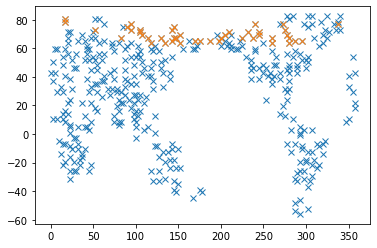

In [16]:
ix = (ds.GPP.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > 60)
ix = (ds.GPP.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > 60) & (ds.ALTMAX.isel(ens=0).max(dim='time')<2)
#ix = (ds.GPP.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > 20) 

#ix = ds.GPP.isel(ens=0).mean(dim='time')>0

plt.plot(ds.grid1d_lon,ds.grid1d_lat,'x')
plt.plot(ds.grid1d_lon[ix],ds.grid1d_lat[ix],'x');
nx=ix.sum()
nx.values
dsreg = ds.isel(gridcell=ix)
lareg = la.isel(gridcell=ix)
dsreg
ix.values

In [44]:
#use the landarea vector and month_wts to calculate average annual
var = "ALTMAX"
vartype = "MAX"
cf = 1  # K
#cf = 24*60*60*1e-9  #PgC

if vartype == "MAX":
    var_domainavg     = (dsreg[var]).mean(dim='gridcell')
    var_domainavg_ann = cf/(month_wts(10).mean())*(month_wts(10)*var_domainavg).groupby('time.year').max()
    var_avg = var_domainavg_ann.mean(dim='year').compute()
    
if vartype == "MEAN":
    var_domainavg     = (dsreg[var]).mean(dim='gridcell')
    var_domainavg_ann = cf/(month_wts(10).mean())*(month_wts(10)*var_domainavg).groupby('time.year').mean()
    var_avg      = var_domainavg_ann.mean(dim='year').compute()
    
if vartype == "SUM":
    var_domainavg     = (lareg*dsreg[var]).sum(dim='gridcell')
    var_domainavg_ann = cf*(month_wts(10)*var_domainavg).groupby('time.year').sum()
    var_avg      = var_domainavg_ann.mean(dim='year').compute()
    var_std      = var_domainavg_ann.std(dim='year').compute()

var_avg

<xarray.DataArray (ens: 373)>
array([0.88322473, 0.88189835, 0.88485708, 0.8834174 , 0.88245504,
       0.88428806, 0.88206512, 0.88357924, 0.88334376, 0.88121712,
       0.8824734 , 0.8840407 , 0.88255585, 0.88374342, 0.88145611,
       0.8836618 , 0.88373007, 0.88004569, 0.88095571, 0.88380784,
       0.88378552, 0.86689053, 0.88229956, 0.88687508, 0.87957526,
       0.88388933, 0.88139786, 0.88784754, 0.88001325, 0.87990591,
       0.88588423, 0.88709969, 0.88309262, 0.888479  , 0.90965959,
       0.87045685, 0.927436  , 0.85369   , 0.89115593, 0.88346276,
       0.88297902, 0.88389194, 0.89802985, 0.8302521 , 0.88342405,
       0.88299122, 0.85461699, 0.90773305, 0.88014483, 0.88585929,
       0.87849471, 0.88782445, 0.88079432, 0.88545306, 0.88345517,
       0.88266235, 0.88428324, 0.88264197, 0.89502757, 0.87203055,
       0.88567222, 0.87891407, 0.79388759, 0.96677368, 0.86426537,
       0.93119937, 0.75172759, 1.12478849, 1.10457491, 0.73351139,
       0.88365078, 0.88260449, 0.88538684, 0.87950152, 0.88388736,
       0.88322473, 0.8847793 , 0.87992525, 0.88379351, 0.87337221,
       0.88397463, 0.88360113, 0.91147214, 0.87365968, 0.88339973,
       0.88546349, 0.87958051, 0.88148191, 0.88291184, 0.88379077,
       0.8834536 , 0.88348799, 0.88280724, 0.88360238, 0.88390368,
       0.88403249, 2.91096016, 0.80862755, 0.91192453, 0.89515846,
...
       0.88321896, 0.88391073, 0.88361189, 0.88403301, 0.88347735,
       0.8839956 , 0.88367184, 0.88322473, 0.88322473, 0.88303169,
       0.8832338 , 0.88320761, 0.88331475, 0.88322473, 0.88322473,
       0.88328001, 0.88391347, 0.88322473, 0.88322473, 0.88410935,
       0.88359955, 0.88394124, 0.88383021, 0.88345116, 0.88368868,
       0.88370471, 0.88324855, 0.88379579, 0.88331468, 0.88352125,
       0.88388174, 0.88338358, 0.8837518 , 0.88366768, 0.88386042,
       0.88419181, 0.88386794, 0.88346763, 0.88374678, 0.88369547,
       0.88372177, 0.88311665, 0.88366953, 0.88333364, 0.88360521,
       0.88362484, 0.88349004, 0.87967456, 0.988477  , 0.87955677,
       0.90891853, 0.8769733 , 0.97745485, 0.89943068, 0.87716312,
       0.89723727, 0.88088056, 0.8828049 , 0.88571578, 0.8875541 ,
       0.88119574, 0.87501136, 0.88701256, 0.87265684, 0.88520635,
       0.87383553, 0.88697849, 0.97848876, 0.88209176, 0.886874  ,
       0.88008551, 0.88473697, 0.8730536 , 0.88702977, 0.87290797,
       0.88322473, 0.88322473, 0.89882966, 0.8927607 , 0.88333074,
       0.8815557 , 0.88305921, 0.8818055 , 0.88359278, 0.88329645,
       0.88337813, 0.88408266, 0.74451029, 0.89063825, 0.84080688,
       0.89194835, 0.87643542, 0.85348359, 0.88424559, 0.88065764,
       0.88360919, 0.88379901, 1.08101269])
Dimensions without coordinates: ens

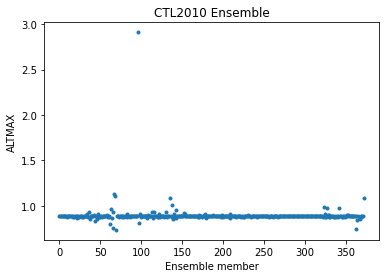

In [45]:
var_avg.plot.line('.')
plt.xlabel('Ensemble member')
plt.ylabel(var)
plt.title(name+' Ensemble');

In [46]:
#which perturbations yield the bottom 10 lowest Soil temperature?
print('LOW ',var)
for i in np.argsort(var_avg)[:10]:
    p = str(dsreg.param[i].values)
    m = str(dsreg.minmax[i].values)
    print('   '+p+'-'+m)

print('HIGH ', var)
for i in np.argsort(var_avg)[-10:]:
    p = str(dsreg.param[i].values)
    m = str(dsreg.minmax[i].values)
    print('   '+p+'-'+m)

LOW  ALTMAX
   watsat_sf-max
   om_frac_sf-max
   sucsat_sf-min
   bsw_sf-min
   upplim_destruct_metamorph-max
   zetamaxstable-max
   slopebeta-max
   pc-max
   frac_sat_soil_dsl_init-min
   jmaxb0-max
HIGH  ALTMAX
   bsw_sf-max
   tpuha-max
   lmrhd-min
   vcmaxha-max
   jmaxb0-min
   om_frac_sf-min
   lmrse-max
   watsat_sf-min
   sucsat_sf-max
   upplim_destruct_metamorph-min


In [47]:
lp = np.argsort(var_avg)[:10]
hp = np.argsort(var_avg)[-10:]
#p = xr.concat(lp,hp,'ens')
print(dsreg.param.isel(ens=lp))
lp

<xarray.DataArray 'param' (ens: 10)>
array(['watsat_sf', 'om_frac_sf', 'sucsat_sf', 'bsw_sf',
       'upplim_destruct_metamorph', 'zetamaxstable', 'slopebeta', 'pc',
       'frac_sat_soil_dsl_init', 'jmaxb0'], dtype='<U32')
Dimensions without coordinates: ens


<xarray.DataArray (ens: 10)>
array([ 69, 362,  66,  62,  97,  43, 364, 367,  37, 139])
Dimensions without coordinates: ens

### calculate parameter effect
- i.e. max perturb -  min perturb

In [48]:
cf = 1
da = dsreg[var]
# set uniques
#uniques = ['kmax','krmax','psi50','ck']
# get unique from a prior list
#uniques = ds.param.isel(ens=lp).values
# get from whole list
uniques = np.unique(dsreg.param.values)

mean,iav,spatial,xdefs=param_effect(da,dsreg.param,uniques,cf,vartype)

C2_liq_Brun89
CWD
FR
FUN_fracfixers
KCN
LF
Q10
a_coef
a_exp
accum_factor
akc_active
akn_active
aq_sp_yield_min
baseflow_scalar
boreal_peatfire_c
br_mr
br_root
bsw_sf
cc_dstem
cc_leaf
cc_lstem
cc_other
ceta
ck
cmb_cmplt_fact_cwd
cmb_cmplt_fact_litter
cn_s3_bgc
cp25_yr2000
cpha
croot_stem
cropfire_a1
cryoturb_diffusion_k
csoilc
csol_clay
csol_om
csol_sand
cv
d_max
decomp_depth_efolding
default
denitrif_nitrateconc_coefficient
denitrif_nitrateconc_exponent
denitrif_respiration_coefficient
denitrif_respiration_exponent
displar
dleaf
drift_gs
e_ice
ekc_active
ekn_active
enzyme_turnover_daily
eta0_vionnet
fbw
fd_pft
fff
flivewd
fm_droot
fm_leaf
fm_lroot
fm_lstem
fm_other
fm_root
fnps
frac_sat_soil_dsl_init
freelivfix_intercept
freelivfix_slope_wet
froot_leaf
frootcn
fsr_pft
fun_cn_flex_a
fun_cn_flex_b
fun_cn_flex_c
grperc
hksat_sf
ignition_efficiency
interception_fraction
jmax25top_sf
jmaxb0
jmaxb1
jmaxha
jmaxhd
jmaxse_sf
k_nitr_max_perday
kc25_coef
kc_nonmyc
kcha
kmax
kn_nonmyc
ko25_coef
ko

/glade/work/dlawren/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/work/dlawren/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


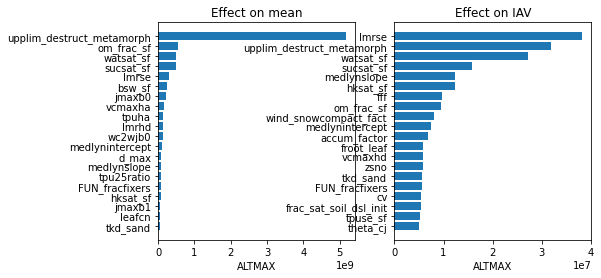

In [49]:
nump = 20
mean_sort = np.argsort(mean)[-nump:]

plt.figure(figsize=[12,4])
plt.subplot(131)
plt.barh(range(nump),mean[mean_sort])
plt.yticks(range(nump),uniques[mean_sort])
plt.xlabel(var)
plt.title('Effect on mean');

iav_sort = np.argsort(iav)[-nump:]
plt.subplot(132)
plt.barh(range(nump),iav[iav_sort])
plt.yticks(range(nump),uniques[iav_sort])
plt.xlabel(var)
plt.title('Effect on IAV');